<a href="https://colab.research.google.com/github/LJmeteor/NLP_Evaluating-descriptive-answers/blob/main/Tensorflow_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 30.8 MB/s 


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text 

In [4]:
import pandas as pd

In [5]:
data = pd.read_csv('/content/666.txt')
data.head(10)

,Category,Message
0,correct,Project management is the use of specific know...
1,correct,All projects are a temporary effort to create ...
2,correct,The changing nature of work due to technologic...
3,correct,Some projects are needed to quickly resolve pr...
4,correct,"Throughout human history, project management h..."
5,correct,It is now widely acknowledged that a basic kno...
6,correct,Projects should be chosen and prioritized base...
7,correct,"The idea is to create a concise, collaborative..."
8,correct,Use an empathy map to document and detail the ...
9,correct,Use an empathy map to document and detail the ...


In [6]:
data.groupby('Category').describe()

Message                                                            \
            count unique                                                top   
Category                                                                      
correct        15     15  Project management is the use of specific know...   
incorrect      15     14  The marketing mix, which outlines the specific...   

                
          freq  
Category        
correct      1  
incorrect    2

In [7]:
df_correct=data[data['Category']=='correct']
df_correct.shape

(15, 2)

In [8]:
df_incorrect=data[data['Category']=='incorrect']
df_incorrect.shape

(15, 2)

In [9]:
df_balanced=pd.concat([df_correct,df_incorrect])
df_balanced.shape

(30, 2)

In [21]:
df_balanced['incorrect']=df_balanced['Category'].apply(lambda x: 1 if x=='incorrect' else 0)
df_balanced.sample(10)

,Category,Message,incorrect
12,correct,FINISH-TO-START The predecessor task must fini...,0
21,incorrect,Practice tended to be seen as a creative indus...,1
5,correct,It is now widely acknowledged that a basic kno...,0
16,incorrect,"Attempts to create awareness of, loyalty to, a...",1
17,incorrect,"The marketing mix, which outlines the specific...",1
2,correct,The changing nature of work due to technologic...,0
8,correct,Use an empathy map to document and detail the ...,0
29,incorrect,Leasing: Businesses tend to lease expensive it...,1
0,correct,Project management is the use of specific know...,0
25,incorrect,Consumer-to-business marketing or C2B marketin...,1


In [22]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test=train_test_split(df_balanced['Message'], df_balanced['incorrect'], stratify=df_balanced['incorrect'])

In [23]:
X_train.head(5)

3     Some projects are needed to quickly resolve pr...
0     Project management is the use of specific know...
29    Leasing: Businesses tend to lease expensive it...
13    FINISH-TO-FINISH The successor task cannot fin...
2     The changing nature of work due to technologic...
Name: Message, dtype: object

In [12]:
bert_preprocess=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [14]:
# define function to see senten matrix
def get_sentence_embeding(sentences):
   preprocess_text=bert_preprocess(sentences)
   return bert_encoder(preprocess_text)['pooled_output']
get_sentence_embeding([
    "I am man",
    "I am women"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.89940226, -0.29733068,  0.2518667 , ...,  0.26192605,
        -0.6011016 ,  0.91771156],
       [-0.86019045, -0.2627165 ,  0.3662255 , ...,  0.26897055,
        -0.5624749 ,  0.8998403 ]], dtype=float32)>

In [15]:
# functional model
#bert layers
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocess_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocess_text)
# Neural network layers
l=tf.keras.layers.Dropout(0.1, name="Dropout")(outputs['pooled_output'])
l=tf.keras.layers.Dense(1, activation="sigmoid", name='output')(l)

#construct final model
model= tf.keras.Model(inputs=[text_input], outputs=[l])

In [ ]:
model.summary()

In [17]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name="recall")
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train,y_train, epochs=100)

In [27]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 3s 3s/step - loss: 0.4817 - accuracy: 0.7500 - precision: 1.0000 - recall: 0.5000


[0.48168516159057617, 0.75, 1.0, 0.5]

In [28]:
y_predict=model.predict(X_test)
y_predict=y_predict.flatten()

In [29]:
import numpy as np
y_predict=np.where(y_predict>0.5,1,0)
y_predict

array([1, 0, 0, 0, 0, 1, 0, 0])

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_predict)


Text(33.0, 0.5, 'Truth')

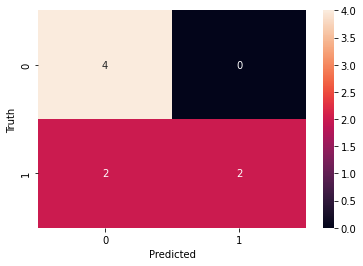

In [34]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [35]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.50      0.67         4

    accuracy                           0.75         8
   macro avg       0.83      0.75      0.73         8
weighted avg       0.83      0.75      0.73         8



In [36]:
answer_list=[
    'Project management is the use of specific knowledge, skills, tools, and techniques to deliver something of value to people. The development of software for an improved business process, the construction of a building, the relief effort after a natural disaster, and the expansion of sales into a new geographic market—are all examples of projects.'
]
model.predict(answer_list)

array([[0.38658446]], dtype=float32)

In [37]:
model.save('/content/my_model')

In [38]:
new_model = tf.keras.models.load_model('/content/my_model')